# HaskellR Tutorial
* Standard Haskell is declarative, statements are not sequenced (unless in a do construct), and variables are immutable. In contrast, this Jupyter kernel permits Haskell to be used like R in the sense that statements in each cell are run in order, variables are mutable, and computations in one cell can have side effects in other cells (the last feature requires some care). Cells of this tutorial notebook should be run in order.
* It follows that the code in this notebook cannot be saved as-is and compiled using GHC. For this reason there is a companion Haskell script __tutorial.hs__ that can be used to run all of the examples via a Haskell program that can be compiled using GHC. The file __tutorial.hs__ is organized as an interactive application, like __H__ and __IHaskell__, with heavy use of the IO monad. The file __lifting.hs__ provides a simple example of a more type-safe organization.
* To run the tutorial from the HaskellR root directory use 'stack --nix exec tutorial' on Unix-like systems (omit the --nix for Windows).
* For more information (including mathematical details) about FFT and Wavelet functions used in these tutorials see the Hackage documentation for the __mathlist__ package.
* Note that 'r' should not be used as a local variable name in Haskell code that uses quasiquotes, and there should be no space between 'r' and '|' in a quasiquote (similarly for rgraph and rprint).
* Useful Jupyter hotkeys:

| Command | Result |
|---------|---------|
|TAB| command completion|
|Shift-Enter| execute current cell|
|Ctrl-Z| undo typing/delete|
|Ctrl-Shift-+| increase font size|
|Click left border of chart cell| toggles scrollbars|
|Shift-Up/Down| select multiple cells|
|Shift-M| merge selected cells|
|Ctrl-Shift-P | show palette of all commands|

In [6]:
:ext QuasiQuotes
:ext ViewPatterns
:ext DataKinds
:ext ScopedTypeVariables
:ext GADTs

In [7]:
import qualified Language.R as R
import Language.R (R)
import Language.R.QQ
import Data.Int (Int32)
import Data.Complex
import qualified Data.Vector.SEXP as V
import qualified Data.Vector.SEXP.Mutable as M
import qualified H.Prelude.Interactive as I
import qualified Language.R.Debug as D

In [8]:
import Math.List.FFT
import Math.List.Wavelet

In [9]:
-- Initialize an R instance
import qualified H.Prelude as H
H.initialize H.defaultConfig

## Elementary R interactions

In [10]:
-- Here [r|<code>|] is a quasiquote that permits insertion of R code into a Haskell program.
-- The result is a SEXP contained in a MonadR structure (roughly speaking).
-- The function I.p applied to this structure causes R to display the SEXP result.
I.p [r| sqrt(1:5) |]

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

In [11]:
-- The SEXP itself can be fetched as follows, and placing it on a line by itself
-- causes the corresponding address to be displayed.
sxp <- [r| sqrt(1:5) |]
sxp

0x00007fd294c27b78

In [12]:
-- The function I.printR can be applied directly to such a SEXP
I.printR sxp

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

In [13]:
-- Alternatively, the sxp can be extacted from the result and passed to I.printR
-- using the Haskell bind operator (>>=)
[r| sqrt(1:5) |] >>= I.printR

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

In [14]:
-- Similarly...
I.printR =<< [r| sqrt(1:5) |]

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

In [15]:
-- Haskell supports syntactic sugar that makes this look more imperative...
do
  x <- [r| sqrt(1:5) |]
  I.printR x

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

In [16]:
-- Show R's home directory
I.p [r| R.home() |]

[1] "/nix/store/cz3rd3k8cgwksj3nm1ms5l8cqlda2dvv-R-4.2.1/lib/R"

In [17]:
-- Uncomment the next line to generate a simple R plot in a pop-up.
-- The SEXP address of the result will be displayed but can be ignored in this case.
-- [r| plot(0:200/20, sin(0:200/20)) |]

In [18]:
-- In a Jupyter notebook HaskellR supports two convenience quasiqoutes,
-- rprint and rgraph. rprint elininates the need to use I.p (or I.printR)...
[rprint| sqrt(1:5) |]

[1] 1.000000 1.414214 1.732051 2.000000 2.236068

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAAC/VBMVEUAAAABAQECAgIDAwMEBAQGBgYHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQVFRUWFhYXFxcYGBgZGRkaGhobGxscHBwdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU2NjY3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZHR0dISEhJSUlKSkpLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJTU1NUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tcXFxdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZnZ2doaGhpaWlqampra2tsbGxtbW1ubm5vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGSkpKTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXGxsbHx8fIyMjJycnKysrLy8vMzMzNzc3Ozs7Pz8/Q0NDR0dHS0tLT09PU1NTV1dXW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7///9y/RqeAAAgAElEQVR4nO2dB1gU1964/b4v/+S71+9GEzUxlmuMmtxEEkssbF86SFWqDREEsaHYuxhF0VhAsJcYY6+osaFiQbGLmAgqiCgWVECQzu6e5z8zGCNbp5wpOzPvfZ4xd2fmnGHf3dkzp/x+jYAIr2nE9gWI0IsomOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnmOKJjniIJ5jiiY54iCeY4omOeIgnkOBcEvd4lwgD21dAne2X+NCPtIc2gTnET+XBFohIqC+Y0omOdAEVymM/KiKJgTUBZcOb/Th40+6BhTo79DFMwJKAsO8U4rriu+GBCqv0MUzAkoC25Wif2jaau/QxTMCSgL7rof++d0N/0domBOQFnwpTY2AWGBXVpf198BSfAzTRmUcjhMbb753iZKUG9Fa1LWx609pTF4HYLgqrhuzb7+v46tXLYZa6bzgvI9zp0+/vpfX/VY+JieCmA9B5cc03+FsuDS8OZftl3RJrHlwvb/bpNk+AniAdpfv2/t0mJ1+zXNQ9p9E1VERxWwBF/46N1/Xl6I4TWC/FWh7P3iP10TR3ROa3m6p9c6SS/VI2rFcZEC1WdebUes+ff11tuCOoxr3/saDXXQ0JP1KAWjrze5K3pLgpsi1bvX5ta3m1xrvcGr+5rO0puUyuMgJ1t26bw1pv2h5nnNjrSNW/aFbZOZ8H+K6OuqHBtA/lygHdoi6tMklavExrGDfTeZwu5Ci97NDlAokIOc8pSW9lSqXOQd3TrInWU9FeW9B82FXgtHBceO6A36yBa3dfnnP5D/Df56QQ8pkPc9T6FEznGoubRp6mDHxU2+bNy4cYvGMYroac3mfBEJ+ztMWfCT7Lfo76AieHarSe38H33XvUn3fRpQsqBdK9/2mdta9GjHo7v0zT52tbO+vO3Y+ovYV6Bm74+tHbe031HuErUTcj2UBcc3/uBzDP0dFASfHxb5Z2FbT8dv9tb//+rwH8YvaXLhoa/8GekyOUaRpJvNz9qwjk3H1/cEgp2fdV2sk3bybJkMtyLqt+iUzsZfJy847/vvu35fdNW18986d3dwSAYTwvynkC2TY1SrAtIyPvUf0GHru5cyO3/XSaU7MtcB7gMxdcF1g4y/TlpwtXzu5hq3bt93z3/vxV0t+0pa/TLHdgbJQjnG8bEHB2tvBEnfb1UUSfo8yvpxlP0EqDVxsJGVNuya9Haxk+Jhg1f3Bw++rvW95UlThw+zXO8k8+nay/fTrQ1ezfuml3PPM5M8psGsinuCMzv3GCL1l7W8rff67KajZKODbKbwoNdSK7nYDySP+XmJ3uunA1xe5MtKHF9DrIt7gpVZsvKrQUk/G+wIPJwU8tgrfDb5S+IKWf1zFnksb+VjOEmiicozftC3KyDWxTnBL/qWnJSEfhJu2PecZdv5xozhQG71vdIFsvahyjP7ehjZ1Tdv0YiHPQetglcZ1wS/8W/m7ZidIzO2r+DLqH3nZ9pY/cNw31suZ+87T4s3suuObaeD/is0Rv98cnBN8MjkgTvuq+b9ZHSnS8GS4KPfyi+TvyguoLUDL4aqP1lotDGRb7MoI2fzD+XQauOaYBV4M0nx2Uzjt+GM3u2TlKcKXclfFBfY01QZVQTs64zvlb9e7ZHwlQxajw7HBOe3HbquDvi9MLH7ivOul0CrIn9RHGDfwKgVx5x/GWZid6rk6yTZpcthsKrjluB7tgNj4vtd6GNqf5Vcd9VB1jSR/FWxj3tZzRxVy/BKU/sP+uwoQu9kkOCW4OE3aifJW7k8N3nAkgCbX+WXIveRvyzWUT1Efn9mmB4YexgEXoxXtLsLqTpuCXapQjaJu8wcscgx7hEoGED2othnYSt1751VsjemjxiwqNd6h1+kD+DUxynB2d/+MOguCDD34U1eBkDtdSpDzexyeOQb9+AO3X83c0hdeJeImyAVUq87lwQ/kaZLJ/+n/1Rzx7ySl6y0/bbjRvLXxS6jbiOf47nLzR6zYg+yyR0Kp0IuCV6+B1TtCB5v/qCzP7S2jdX40TE/jQkmpiKbTb+YPeZyCMgO+9r5JZQKuSR4ehqyOTfTwlEzj+oAOB5L7qLY5tj3n/da8Uxh4Sl3ult7X79j8goYNXJIcF3UdzMeg6jjFg6bfwLZJC8leVXskm9fnqxs+eMVS8dFxtxAnhj2wqiSO4J1PglhsjZOky0dd8f59S55U698S8dxkV/Qe/OdSIvHDc1FNnugDCpxR/CVUcgnPDHY8oEnurSwP3NTXk3qqthlywZk88coi8etTgBVB+T7YVTJHcE7VyKbSjz9zIHoT9iMcySuiWU0S1qEZtQMOG3xwDrf4PY2nu5rIdTJHcF3+pYDcNTiHRrBHR1rWXyYzEWxS8jifT0/sdmM51DPBfeAVlVCvU7OCM5Wf91avlBejOPQJStB9bHv75O7LBYp8EU2zzxxHYv1RZvp0MQNZwQr8sClUBdcP6x1Qxy+aDNEforUZbHIRawLB98wgic6oBYIoSXJFcGPscm3eMdQ+hysBmW21jb97rVKC8CNYFzHnnO8vaHLv3dQ/xO5IrjQH93iFYwdN9jKnpTKx3Zq5hYnKcB39HXJV4uejKXen8MVwbXS1ZVgKd7FdSp0OoSjySFVbhK2Hdwb6oz7omXI110no/wV5ojgPPmIzh93mWliGosB60OLsnwdaFkRTxtaO3Srxmus
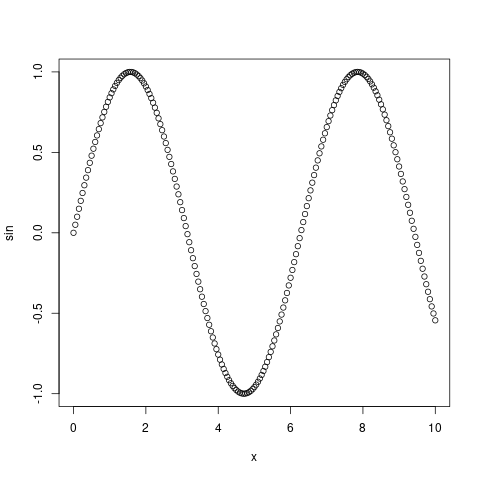

In [19]:
-- rgraph can be used to insert a chart into the notebook (no pop-up).
[rgraph| plot(0:200/20, sin(0:200/20), xlab='x',ylab='sin') |]

In [20]:
-- A data frame
[rprint| data.frame(name=c("john","mary"), id=c(23,56)) |]

  name id
1 john 23
2 mary 56

## Passing Haskell data to R

In [21]:
-- Pass a Haskell Double, Int32, and function to R (all must have '_hs' suffix).
-- Note that R integers are 32-bits, so Haskell 64bit Ints cannot be passed in this way.
-- The function type cast permits it to be used in the R code.
let x = 4.0
    k = 10::Int32
    fn x = return(x^2) :: R s Double
[rprint| k_hs * fn_hs(x_hs) |]

[1] 160

In [22]:
-- Aother example
ints = [1..10]::[Int32]
multiplier = 1.5
[rprint| multiplier_hs * ints_hs |]

 [1]  1.5  3.0  4.5  6.0  7.5  9.0 10.5 12.0 13.5 15.0

## Getting Haskell data from R

In [23]:
-- Here the output from R is captured in a Haskell list of type [Double]
-- R.dynSEXP is a kind of dynamic cast, and R.runRegion makes sure the
-- result is fully-evaluated (Haskell is lazy). The <$> operator permits
-- R.dynSEXP to work on what the value of [r|...|] contains.
x::[Double] <- R.runRegion $ R.dynSEXP <$> [r| sqrt(1:5) |]
x

[1.0,1.4142135623730951,1.7320508075688772,2.0,2.23606797749979]

In [24]:
-- Similarly for a vector of Int32's
y::[Int32] <- R.runRegion $ R.dynSEXP <$> [r| as.integer(1:5) |]
y

[1,2,3,4,5]

In [25]:
-- Work with a data frame...note it is placed in R's global envirnment by (<<-).
I.p [r| mydf <<- data.frame(name=c("John","Mary"), ids=c(2,5)) |]

  name ids
1 John   2
2 Mary   5

In [26]:
-- Fetch colums of data frame saved in global env.
ids::[Int32] <- R.runRegion $ R.dynSEXP <$> [r| mydf$id |]
name::[String] <- R.runRegion $ R.dynSEXP <$> [r| mydf$name |]
name
ids

["John","Mary"]

[2,5]

## Working with R vectors by proxy

In [27]:
-- Useful type synonyms
type RProxyVectorDouble = V.Vector 'R.Real Double
type RProxyVectorInt    = V.Vector 'R.Int  Int32

In [28]:
-- Create R vectors (one real, one int) that can be accessed as if they are Haskell vectors
vecd = V.fromList [1.5,2.0,2.5] :: RProxyVectorDouble -- Vector proxy for 'R.Real that works like Double
veci = V.fromList [1..3] :: RProxyVectorInt
vecd V.! 2 -- (!) is the indexing operator on the Haskell side, but we are looking at an R vector.
veci V.! 0

2.5

1

In [29]:
-- Can pass such vectors to R...
[rprint| list(real=vecd_hs, int=veci_hs) |]

$real
[1] 1.5 2.0 2.5

$int
[1] 1 2 3

In [30]:
-- But they are not mutable. A mutable version can be obtained using V.thaw
vecdm <- V.thaw vecd
vecim <- V.thaw veci

In [31]:
-- Use M.read/M.write to manipulate mutable proxy
M.read vecdm 0 -- get 0 element of R vector behind vecdm
M.write vecdm 0 3.14 -- update this element
-- [rprint| vecdm_hs |] -- ERROR: cannot pass a thawed vector to R, but we can freeze to immutable...
vecdf <- V.freeze vecdm
[rprint| vecdf_hs |] -- OK to pass immutable (frozen) vectors to R.

1.5

[1] 3.14 2.00 2.50

In [32]:
-- Let's pass a 3x4 matrix to R...
matvec = V.fromList [1..12] :: RProxyVectorDouble
rows = 3::Int32
cols = 4::Int32
[rprint| m = matrix(matvec_hs,rows_hs,cols_hs) |]

     [,1] [,2] [,3] [,4]
[1,]    1    4    7   10
[2,]    2    5    8   11
[3,]    3    6    9   12

In [33]:
-- Let's capture the R matrix in a Haskell vector and work with it
-- like a 2d matrix using this matrix indexing function (0-based, not 1-based like R)
-- Of course, Haskell lists are immutable, so this is read-only.
mind :: [Double] -> (Int,Int) -> Double
mind x (i,j) = x !! (i + j*fromIntegral rows) -- R stores by column
x::[Double] <- R.runRegion $ R.dynSEXP <$> [r| matrix(matvec_hs,rows_hs,cols_hs) |]
mind x (0,0)
mind x (1,1)
mind x (1,2)

1.0

5.0

8.0

## Calling R functions from Haskell

In [34]:
-- Interface to call R's fft
r_fft :: [Complex Double] -> R s [Complex Double]
r_fft vec = do
  R.dynSEXP <$> [r| fft(vec_hs) |]

In [35]:
-- Interface to call R's fft with matrix argument
-- Interface to R's 2-dimensional fft()
r_fft2d :: [Complex Double] -> Int -> Int -> R s [Complex Double]
r_fft2d mvec nrows ncols = do
  let nrows32 = (fromIntegral nrows)::Int32
      ncols32 = (fromIntegral ncols)::Int32
  R.dynSEXP <$> [r| fft(matrix(mvec_hs, nrows32_hs, ncols32_hs)) |]

In [36]:
-- Test 1D r_fft (cannot use [1..4] here because Complex has no Enum instance)
x1d <- R.runRegion $ r_fft [1,2,3,4]
x1d -- answer as Haskell List
[rprint| fft(1:4) |] -- answer as displayed by R

[10.0 :+ 0.0,(-2.0) :+ 2.0,(-2.0) :+ 0.0,(-2.0) :+ (-2.0)]

[1] 10+0i -2+2i -2+0i -2-2i

In [37]:
-- Utility to print vector of Complex in matrix format
printMatrix :: [Complex Double] -> Int -> Int -> IO ()
printMatrix mvec nrows ncols = mapM_ printRow [0..(nrows-1)]
   where
     get i j = mvec!!(j*nrows+i)
     
     printRow :: Int -> IO ()
     printRow i = do
       mapM_ (printCell i) [0..(ncols-1)]
       putStrLn "\n"
       
     printCell :: Int -> Int -> IO ()
     printCell i j = putStr (show (get i j) ++ " ")

In [38]:
-- Test r_fft2d
x2d <- R.runRegion $ r_fft2d [1,2,3,4,5,6,7,8,9,10,11,12] 3 4
printMatrix x2d 3 4
[rprint| fft(matrix(1:12,3,4)) |]

78.0 :+ 0.0 (-18.0) :+ 18.0 (-18.0) :+ 0.0 (-18.0) :+ (-18.0) 

(-6.0) :+ 3.4641016151377544 0.0 :+ 0.0 0.0 :+ 0.0 0.0 :+ 0.0 

(-6.0) :+ (-3.4641016151377544) 0.0 :+ 0.0 0.0 :+ 0.0 0.0 :+ 0.0

             [,1]    [,2]   [,3]    [,4]
[1,] 78+0.000000i -18+18i -18+0i -18-18i
[2,] -6+3.464102i   0+ 0i   0+0i   0+ 0i
[3,] -6-3.464102i   0+ 0i   0+0i   0+ 0i

## Fetching the result of a quasiquote as a Haskell list

In [39]:
vd::[Double] <- R.runRegion $ R.dynSEXP <$> [r| sqrt(1:5) |]
vd
vi::[Int32] <- R.runRegion $ R.dynSEXP <$> [r| as.integer(1:5) |]
vi

[1.0,1.4142135623730951,1.7320508075688772,2.0,2.23606797749979]

[1,2,3,4,5]

## Lift a scalar function to apply to vectors in R

In [40]:
-- Scalar function and its lifted counterpart...
let v = [1..5]::[Double]
    f x = return (sqrt x) :: R s Double -- scalar function
    flift = Prelude.mapM f :: [Double] -> R s [Double]
[rprint| flift_hs(as.double(1:5)) + flift_hs(v_hs) |]
-- as.double() is needed here to prevent 1:5 being viewed as a vector of ints.

[1] 2.000000 2.828427 3.464102 4.000000 4.472136

## Calling R's optimizer with functions defined in Haskell

In [42]:
-- Here is a function and its gradient to be passed to R minimizer,
-- with obvious solution (1.0, 2.0).
let fn x y = return ((x - 1.0)^2 + (y - 2.0)^2) :: R s Double
    gr x y = return ([2*(x-1.0),2*(y-2.0)]) :: R s [Double]
    
-- Find min of a function of two variables, where the function
-- and its gradient are defined in Haskell.
-- BFGS solution is (p1,p2) = (1.0,2.0) as expected.
[rprint| library(optimx)
         fn <- function(v) fn_hs(v[1], v[2])
         gr <- function(v) gr_hs(v[1], v[2])
         optimx(c(0.0,0.0), fn, gr, control=list(reltol=1e-12)) |]

                   p1       p2        value fevals gevals niter convcode kkt1
Nelder-Mead 0.9999989 1.999999 1.573351e-12     91     NA    NA        0 TRUE
BFGS        1.0000000 2.000000 0.000000e+00      4      3    NA        0 TRUE
            kkt2 xtime
Nelder-Mead TRUE 0.001
BFGS        TRUE 0.000

## Use R's root finder to compute Black-Scholes implied volatility

In [43]:
-- Home brew cummulative normal using Abramowitz and Stegun formula 7.1.26
-- Thanks to John D. Cook for the pointer.
cumNorm :: Double -> Double
cumNorm x = (2.0 - t*(a1 + t*(a2 + t*(a3 + t*(a4 + t*a5))))*exp(-x^2/2.0))/2.0
    where
        a1 =  0.254829592
        a2 = -0.284496736
        a3 =  1.421413741
        a4 = -1.453152027
        a5 =  1.061405429
        p  =  0.3275911
        t = 1.0/(1 + p*x/sqrt 2.0)

data OptionType = Call | Put deriving(Show,Enum)

-- Result: implied volatility appears as $root = 0.1605951, that is 16.06%
let optType = Call
    optPrice = 2.0 -- option price is $2
    spot = 100.0 -- current (spot) price ($100)
    strike = 100.0  -- strike price
    irate = 0.05 -- interest rate (don't use 'r' here!, will conflict with 'r' in quasiquote)
    drate = 0.01 -- dividend rate
    tm = 30.0/365.25  -- time to maturity in years (30 days)
    rateDisc = exp(-irate*tm) -- interest rate discount
    divdDisc = exp(-drate*tm) -- dividend discount
    forward = spot*divdDisc/rateDisc -- forward price
    rootT = sqrt tm
    price sigma = case optType of
        Call -> rateDisc * (forward*cumNorm d1 - strike*cumNorm d2)
        Put  -> rateDisc * (strike*cumNorm (-d2) - forward*cumNorm (-d1))
        where
            d1 = log(forward/strike)/sigma/rootT + 0.5 * sigma*rootT
            d2 = d1 - sigma*rootT
    priceDiff sigma = return (price sigma - optPrice) :: R s Double
    searchInterval = [0.01 ,1.0] :: [Double] -- interval to search
[rprint| uniroot(priceDiff_hs, searchInterval_hs) |]

$root
[1] 0.1605951

$f.root
[1] -9.023359e-08

$iter
[1] 4

$init.it
[1] NA

$estim.prec
[1] 6.103516e-05

## Fourier transform FFT and FFTSHIFT

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAADAFBMVEUAAAABAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQVFRUWFhYXFxcYGBgZGRkaGhobGxscHBwdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU2NjY3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZHR0dISEhJSUlKSkpLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJTU1NUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tcXFxdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZnZ2doaGhpaWlqampra2tsbGxtbW1ubm5vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGSkpKTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXGxsbHx8fIyMjJycnKysrLy8vMzMzNzc3Ozs7Pz8/Q0NDR0dHS0tLT09PU1NTV1dXW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7////isF19AAAgAElEQVR4nO2dC3wM1/7Aj9z4CyJKPdKHal160ahogrzkQTyi3m0aj1JVDUVFLxq9VY/bIqotihJ1VSna0ErqWaFaQmlTWlJCpYgiSDYhQR6S85/ZV7K7M7Nndk52dk5+388nOzPnnP3NL/PdnZ3HmRmEAaZBaicAVC8gmHFAMOOAYMYBwYwDghkHBDMOCGYcEMw4IJhxQDDjgGDGAcGMA4IZBwQzDghmHBDMOCCYcUAw44BgxgHBjAOCGQcEM45LC/ZGP3Cv4WgVQdv83DKp6gzU1jDyANKzxDziaxiisZZv+Lm1u3G2pe8FN3hs8M8EORQhD4JWzoUZwb4oXaq6iuA2vhwbzSMxvr6NUTNf37mWbxiGwtL0I7pnEHqoLvrHDvs53PXtQpCpc6mBgo9ajWA8Gs2weUMftM0wMgF1OItLZqKHKohydjW0ITgHNdn2VIP+17k18diWDSOPY3xhYJNmLxVgcwW/ot1apfSIn3kK573Q2PdTQsF3pz/p6b8R6+PN4Qty3dBxfrhgZi7eG9CgceQJw4clDQVgfDi0QdMBGeahfhVtbFSZsrpoRbB7HV937meyIgA9HVKryfXb3rUHh6CocnPFnpZo3uXKUs8WaKtpqsIfPeHnVim4rb+///AqIxaC+6AWz9ZDK/GejmhqBl/wI3rUVHexbu3IAPREpeCbXm6DI9DD90xDXrCpkTkzldGKYHQYb0BP432ozX083P1/H6HXMQ5C280V+lV0ldIZ18pMUztRq3t4lOVGlm+VkaqCD6EWt3AKasqbTtaXrEd+3KsH1zTt0NAlWFcb5ZsF/4D+eQG/Oz7bNOQFmxpVZqYuWhHcCOMzqDVegl7W14w2bPkmmCv0gitL6xRVtpmL4jDeT7aKXo4mYFxSH101Cz6ImnCvXbgNsTR8LK4b97HINQu+2xShdlPOm4f6VbSxUWVm6uLSgluhndxrZ7Qhh1/KmdzS+gBN1deMRRO/5DhhrtALtig1T01Db2D8HZngZWgi9/owyjYL1rmjvfywLUrb59Zi2fEHecH/Mv4G563q64HqnDINecGmRpWZqYtLC34WDS3Fv/wf+tW8tHahjmV4lOeGxehNjBOn/VZV8FFsUWqe+hS1LsZjyAQfRI8V4gPowcpVNJ6MWvyM707lVtFx6B38K/flPI/q3MLzOMG7Z+zGRT3RCtOQF2xqBIIJ+NkdeT3mhgZh89Iq90Udw2s9lHurqduIAeifRZWLcSDqe9KiFJumdPVRm8BahFvRPdETg+qjFVUE5/sh1Kw26o3SFiOvqHq10JWypqhZBw9O8C7kOTi6bu1TpiEv2NQIBJNwctCjnr4flFYKxjdGPdIw6g+Mz0U1aj7qSpWKH/w8d1uUmtvgQz0a+nxCKPjOv9t4+m3AVQTjktmdG3RNzOn3x73hDdqt74gW4P1PeYZt4FfRG/wbenbZaR7ygk2NQDDgFEAw44BgxgHBjAOCGQcEMw4IZhwQzDggmHFAMOOAYMYBwYwDghkHBDMOCGYcEMw4IJhxSATn618LqjcRoHqwL/hk+1qtkjEuhu+6JrGvLWh6wQHvNBCsUexr8yrEOKVdKQjWJva1Pc33+46ZCIK1iX1tu+r3ysP5XfxAsCYh0HZ5cxHGpVvizQWFWXp++iwJUJ+tpUoF27AnVk+H9omA+gSfpy7YyJQYx98LUOMVpYKvZBqxrgDBLoFiwUs93b31WFdYCf4hV2ZmgGPcOWcxqVgwTvURLrcS/FXABfuxAMXcCv3WYlq54LKRwuXWq+hTUfZjAYqZkGI5rVywGDa/wa/vdzwYQMjFZ60KnCj4wmDHgwGEvLnXqsCJgnHfHMejAUTcDyi3KnGm4HUrHI8GELHP5p58zhSsg82s6maizU1RnSkY97rleDiAhECbO2Y6VfCCbY6HAwg4PcamyKmCf53oeDiAgI832RQ5VXB5iOPhAAIG2+6nOFUwHqz67XOZRugL5FzBH251PB5gl1PjbMuqQbAuXc+w522rjr3hQDyAlFXrbcuqQfBeY4+OXrZVJeEOxANIGSkg07mraNzjnuMBAXsEC5Q5WfC0I44HBOyQO0Cg0MmCtyx2PCBgh53zBAqdLPjScMcDAnaYa32qkMfJgnGo4wEBO/TLEyh0tuB++Y5HBKQRPE7obMGzoN9OdfG34AJ3tuCU9x2PCEiSvEio1NmChT9mAAVm7xMqdbZg2MqqNgS3sUgFn8UlSeskn8Brg4jgvrdlRQGI6SZYSiZ4phee5Os/Qdb8RAT/56CsKAAp158TLCYT/OCF8kaZec1kzVBE8JalsqIApOx5V7CYUHD+j63wlYayZigi+PxoWVEAUubvEiwmEzyu0+Pzr/UcKN5O4NJBEcEVsJVVPbxwRbCYTPD9LQcqshcVCrW4/nLn+Jud3J48Y10hdn1wZLHkHAEHEd7GUr6b1P/5rf2bJtyeG2kuuWns0TFE+A1xv9qNCcinsK9wOZng/cE+PEItvApwtkcJLmpkLjkQr8e/t3DIz/5nP1tANmk2F60YIBPcdc7vGRxCLdpsxxvQGXy8lXWF2Cr6t0mScwQc4+Mk4XIywS3FW2yr6918xSMvN7W5sExMcGl3yTkCjvHKWZFyIsEzlgluYOnJPVqED83+zqZc9CYsodZXOAIUCBNZqiSCfXzao9rtRX6DRREVLPZZAxRQIrZeJBGcYULWLEUFL/9SVhyAhOOTRSrk7SZNlTFLUcGH35QRBSBj7VqRCnmCx8uYpajgO31kRAHImPSbSIUKgsWOuQAKiBC756gagkdclBEGIOF+mFiNGoI/+lpGGICEU6Jm1BD8w9sywgAkrE8Uq1FDsNhxccBhJh8Xq5HXJ8vmnKAEErcThjs50KZ7iViN0/tk
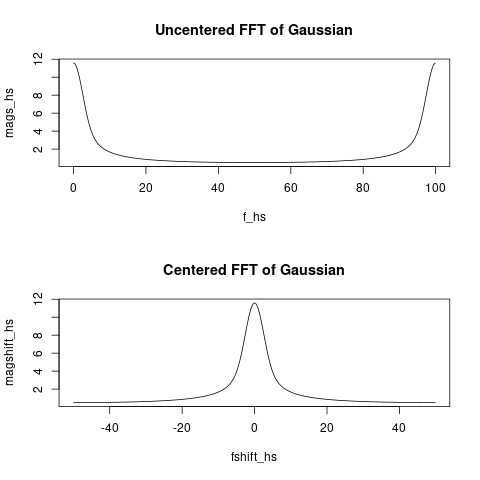

In [44]:
n = 1024 -- number of sample points
dt = 10.24/fromIntegral n -- time increment
df = 1.0/dt/fromIntegral n -- frequency increment
t = take n $ iterate (+ dt) 0 -- time grid
f = take n $ iterate (+ df) 0 -- freq grid
fs = 1.0/dt -- sampling rate
signal t = exp(-64.0*t^2) -- Gaussian function
gauss = map ((:+ 0) . signal) t -- sample and complexify
ft = fft gauss -- standard unshifted fft
mags = map magnitude ft -- modulus vector
ftshift = fftshift ft  -- shifted (rotated) transform
magshift = map magnitude ftshift -- modulus vector
fshift = take n $ iterate (+ df) (-fs/2) -- shifted frequencies
[rgraph| save = par(mfrow=c(2,1))
         plot(f_hs, mags_hs, type='l',main='Uncentered FFT of Gaussian')
         plot(fshift_hs, magshift_hs,type='l',main='Centered FFT of Gaussian')
         par(save) |]

## Analytic signal and Hilbert transform

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOzdeUDM6R8H8Pd06U7KLZQ7Z44oR1i5j1BE5D5W7mvddrHYdbPEIpLcCjlikdu6fu7kriyRDnSf8/tjlu021cz3eb4zn9dfmuN53s3o07dnnkMilUpBCCGEPxqsAxBCCMkbFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhCCOEUFWhBpaSkzJ8/39bW1sjIqE6dOkOGDHn79m1+D05ISJBIJHp6eorNoKRmC2j56dOnEomkRo0agoVJSUmRSCQSiSQsLOzbjV26dJFIJKtWrcraadZ/F5CzUD59+hQdHZ2enl6ouxTu1q1bNWrU0NbW3rJliwDdFc3jx48lEkmdOnVYB+GUFusAaiQ2NrZNmzaPHj0CUK5cuWfPnoWEhBw/fvzkyZPNmzfP/XgNDY1GjRrp6OgoNoaSmhURZb8C7dq1u3fv3u3bt5s0aSL/XQq3Zs2aFy9eODg41KtXT9l9ESWhK2jhzJ0799GjR/Xq1Xv+/HlERERMTIyzs3NMTMzo0aMzMjJyP15PT+/u3bs3btxQbAwlNSsiavIKxMbGApg8eXLLli1ZZyFFRAVaIJGRkbK/NHft2lW9enUAJiYm3t7eZcqUefDgwbFjxz58+CCRSEqXLn39+vWmTZsePnw4x5//iYmJHh4e5ubmdnZ2W7dulUgkLi4uBXd67do1BwcHY2PjMmXK9OrV6/Hjx8g1qpBfs9/yHDlypF69esbGxj179oyMjJQ966+//rKzszM2NjYzM3N0dLx37548L8LKlSsrV65saWn5888/S6XSHPfm+Gv36tWrEonEzs5O9mVoaKiTk1Pp0qXLli07dOjQz58/y9Njnr47rpJnzjwD5H7XbGxsZK+G7Muszea4K/dzkc8LW/B7kee7bGNjExgYCKB3796//PILgKSkpJkzZ9aqVcvIyKhZs2Z79uyRPT13jJcvX0okEktLy8mTJ5csWbJq1arr16+/fv16kyZNjIyM2rdvn3XgKL9GCnjLYmJi+vfvb2ZmZmNjc/369SK/j2pBSgRx9uxZAJaWljlud3d3B7Bw4cL3798DMDQ0tLCwAHDo0KH4+HgAurq6skeOGjUKQKVKlWxsbLS1tQE4OzsX0OPHjx+NjY01NDR69+7drl07ABUqVEhKSpKzWVkeLS2tEiVKNGrUSEtLC8DIkSOlUmloaKienp62tnaHDh1atGjx7fvK0fI3ISEhADQ0NHR1dR0cHIyMjADMnj07x1Nkgz+1a9eWPevKlSsAWrRoIZVKv3z5Uq5cOW1t7d69e7dq1QpAly5dMjIy8vvek5OTZf+969ev3/QrY2NjACtXrszaadZ/F5AzvwC537XAwMAqVaoA+PXXX9+8eZM1VY67cj83vxe2gPciv3c5MDCwYcOGAKZNm/bo0SOpVNq5c2cAFhYW3bp109fXB+Dp6fmt8awxXrx4IXv19PX169atK/u3jo6OrLgD6NevX44XPHcj+b1imZmZTZs2lX1rTZo00dDQyPqmkxyoQAvkzz//BNCyZcsct8+ZMweAm5ub7L84gFmzZkVERKSlpWWtHbKLGn19/ZiYGKlU2r179+8W6AsXLgCoVq3a69evpVLp4sWLx44dGx4eLmez3/JcvXpVKpX6+PgAaNCggVQqvXz5squr69q1a6VSaUxMjKysx8bGFlygZT+3Uqn02rVrAAwMDBISEuQs0KtXrwYwYcIE2V329vYAAgIC8vvevxXo3L5boPPMmV+A3O+aVCpt1KgRgNu3b+cOlvWu3M/N74Ut4L3I712Wfq3IR44ckb1lsur8+fNnqVR69OhRAKVLl84zhqxASySSV69eSaVSWXkdNGiQVCr966+/8qynuRvJ7xU7ceIEACsrq6SkJOnXCxQq0PmhIQ6BWFpaAoiIiMhxu+yWqlWryr4sUaLEvHnzypUrJ7tK+ubevXtSqbRly5ampqYA+vbt+90ebW1tS5cu/fLlS0tLS2tr6+jo6OnTp8sucORv1tTUVPajJbvqSUxMBNCqVaspU6a8fv26TZs2VlZWaWlpAPIcRs9KT0+vW7duAOzs7CwsLBISEp48efLd70LmwYMHADZs2CCbmyErnbK/5QsWGhr67f+67NfPd+WZs+AA+b1r8sj63IJf2DzfC3neZQD3798H0KNHD9mfEZ07dzYwMPj48eO3/5C5vwULCwvZf9pKlSoBkF2ey1rObxZK1kbye8Vu374tS6KrqwtgyJAhhX3F1ArN4hBI/fr1JRLJ69ev79+/L/vbE4DsT1EANjY2sluMjIwMDAxyP1320/ht4oHsP3fB9PT0QkJCDh48eOzYsfPnz69du9bT0/P27duynzo5m9XU1JT9QyKRfLvx3LlzHTt2rFix4syZM9etW+fo6BgdHf3dPNIsg86yZrO2mefDvpFVDQ8Pj9atW3+7sVatWt/ttAjyzFlwgPzeNXlkfW7BL2ye70V+73KOmRuyb+rbE3V0dExMTBISEtLT02Xvfu5vQTb4kLt3Ob+X/F4xX1/frI0LM+NQvOgKWiBly5aVDRq6u7u/fPkSwJcvX4YMGRIREVG3bt1evXoV/HRra2sAly5diouLA+Dn5/ftLqlU+uHDhw8fPuQobYGBgStWrKhSpcqJEyeioqIcHR1TUlIuXbokZ7MFCAgIyMzMHDp06Pjx46VSqTzVGUBycvLp06cB3LlzJzQ0VF9fv3bt2lkfIPv1EBoa+uXLFwAXL178dpdsJNTAwKB///79+/f//Pnz7du3JRJJft97ceSZM78ABbRTQOnJ764ivLDyvMsAZNcEAQEBsiGdCxcuvHv3zszMLPe1tqLk94rJfqsFBASkpKQA2L9/v5ICqAhhR1TUWlRU1LcpCuXLl5ddkpQsWfLatWvSr6N45ubm3x6fY0hXdiViZWXVvHlzWWmQDRZHRUXJ2oyKisra3cmTJwEYGhr27t3bxcVF9unTw4cP5Ww2Rx7Z+Gz16tWlUumaNWsAGBsbd+nSRV9fX/ast2/ffncMWl9fv0OHDiYmJgDmzZuX43tMS0srXbo0gDJlytSvX19Wr2Vj0J8/fy5durSGhoabm1vPnj0BVKtWLT4+Pr/v/dsYdO4hDnnGoHPnzC9A7ndNKpXKft127dr1wYMHOV6KrHflfm5+L2wB70V+77I0+xi0VCp1dHQEYGlp6eTkJLvO3bhxY57/8WRj0FWrVpV96erqCmDnzp05us4qdyP5vWIxMTGy3mvUqGFnZyf7HmkMOj90BS0cMzOzO3fuzJo1q3Hjxl++fKlevfrgwYMfPnz4bSZZwfz8/Pr27RsTE5Oamrpu3brvPr5Lly4+Pj61a9c+f/78qVOn6tevL5ukVcxmAYwdO3bgwIFSqTQ0NHTz5s0NGjQAsGvXroKfVbFiRXd394cPH5qYmCxcuFA29ysrLS2tffv21a1bNzExsVSpUlu3bv12l7Gx8dWrVzt16nTy5MkbN264u7tfunSpyKMKRchZqABTpkxp0qTJpUuXci8TLeAuFOmFlfNdBnDkyJGpU6dqaWmdPXu2du3aPj4+48aNk/M1KYL8XjFTU9PAwMAffvghMjIyLi5u48aNysugAiRSxf1tSJQnJibm8uXLJUqUkF0WrV69etq0aZMnT5Zdc/HWrJDS09PNzMyioqJkcx4IUSX0IaE4ZGRkuLm5JSQkzJkzx9zcfMWKFRoaGs7Oznw2K5jU1NQRI0Z06dKFqjNRSXQFLRrXr1+fN2/e3bt3MzIy6tatO2fOHDnnjTFpVhiJiYlHjx51cXEpwvw2
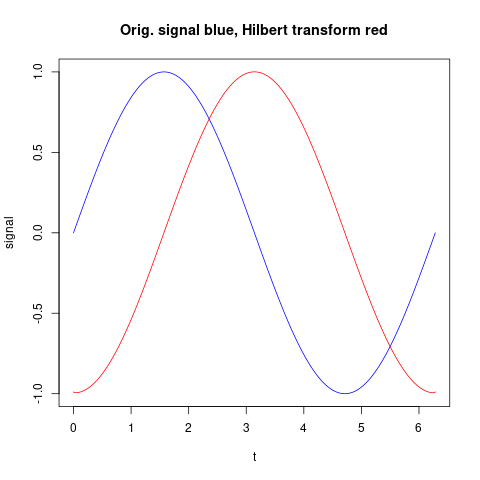

In [45]:
n = 1024 -- number of sample points
dt = 2*pi/fromIntegral (n-1) -- time increment
t = take n $ iterate (+dt) 0 -- time grid
sig = [z | k <- [0..(n-1)], let z = sin (t!!k)] -- sine wave
z = analytic sig -- analytic signal
zr = map realPart z
zi = map imagPart z
innerProduct = sum $ zipWith (*) zr zi -- should be zero
[rgraph| plot(t_hs, zr_hs, xlab='t',ylab='signal',type='l',col='blue',
           main="Orig. signal blue, Hilbert transform red")
           lines(t_hs, zi_hs,type='l',col='red') |]

## 3D Plot of Complex Gamma Function

In [46]:
gamma :: Complex Double -> Complex Double        
gamma z = if realPart z < 0.5 
          then
            pi/(sin(pi*z)*gamma(1.0-z))
          else
            val
  where g = 7 -- length p - 2
        z' = z-1
        x = head p + sum [y | j <- [1..(g+1)], let y = p!!j/(z' + fromIntegral j)]
        t = z' + 0.5 + fromIntegral g
        val = sqrt(2*pi) * (t**(z'+0.5)) * exp(-t) * x
        -- p is not recalculated for each call (memoization).
        p = [0.99999999999980993
            , 676.5203681218851
            ,-1259.1392167224028
            , 771.32342877765313
            ,-176.61502916214059
            , 12.507343278686905
            ,-0.13857109526572012
            , 9.9843695780195716e-6
            , 1.5056327351493116e-7
            ]

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOydeXxTVfr/P9natEnadG9aui8UKHSF7guyVkT0K6Lj+v3qOCPjVx2V0RmH0XE2l/nNgDrjqMzMFxdUVBAGQWQpQgu0LK2UtnTfk+5t2qTNnvv7417T0tKSxJYm1/N+8cdNcnLOuc3lc5/7nOc8D4eiKBAIBALB8eDO9QQIBAKBcG2IQBMIBIKDQgSaQCAQHBQi0AQCgeCgEIEmEAgEB4UINIFAIDgoRKAJBALBQSECTSAQCA4KEWgCgUBwUIhAEwgEgoNCBJpAIBAcFCLQBAKB4KAQgSYQCAQHhQg0gUAgOChEoAkEAsFBIQJNIBAIDgoRaAKBQHBQiEATCASCg0IEmkAgEBwUItAEAoHgoBCBJhAIBAeFCDSBQCA4KESgCQQCwUEhAs0qhoaGON9x5MgR+s1Lly5Z3qyqqrK+t6qqKg6Hs2DBgumbjYyMcDgcNzc3++dtHefPn4+JiREIBO+8887kT4eGhh5//PGEhAQPD4+MjIytW7fqdLrZntLMnrvBYPjjH/+YnZ3t4eERFhb2X//1X+fPn5+RnglOCn+uJ0CYLUpKSlavXg2ANf/Jt23b1tDQkJeXFx8fP+Gjtra2vLy8lpYWAP7+/iUlJSUlJceOHfvqq6+8vLzmYK62Mzg4uHLlyrKyMgAymay3t/eLL774z3/+s3///nXr1s317AhzA7Gg2YlQKCwpKaGPz5075+LiwuU6/W89ODgI4Oc//3lWVtaEj55//vmWlpakpKS2trbu7u6ampqwsLDS0tLXXnttLmZqD1u3bi0rK1u8eHFtba1CoVAqlVu3bjWZTI888ghFUXM9O8IcQRFYhFKppH/WrKwsb29v+s2EhIS0tDQ+nw+gsrKSoqjR0dFf/OIXsbGxYrE4NTV1165dlh76+/s3bdrk7e2dmJi4Y8cOAHFxcRRFVVZWWo4piiouLgaQnp5OUZRarQYgFAqnb0ZR1OnTp3NzcyUSiZ+f36233kpPZgJTzS0xMdFy0f72t78d/5Xe3l4OhwPg4sWLljc///zzlStXPvPMM9P02dDQACA8PPzJJ5/09PQMCwt7/fXXz5w5k5ycLBaLly9f3tLSMv6k3nnnnfDw8NDQ0C1btmi12gnnTlFUc3Pzhg0bfH19/f39H3zwQaVSSVHU22+/DcDPz0+lUnV3d4tEIgB79+4dfwp9fX30HbSsrGz8+y+//PLWrVv7+vooijpy5Eh6erpEIvH29l65cmV5ebn1p2Bls6lGIcwVRKBZhUWgn3nmGQB1dXUjIyM8Hu/JJ58cL9Br164FEBISsm7dOnd3dwD/+Mc/KIoym82pqakAIiIiUlJSaMmYKYHu7e318PDgcrm333778uXLAQQFBWk0mgmnMNXcDh8+nJCQQJ/aBGU/ffo0gMDAwKn+LFP1ScsWAHd390WLFtHHLi4u8+fPl0gkADZt2mQ5KaFQKBKJ8vLy6I8efvjhCec+PDwcGBgoEAhuv/327OxsAAUFBSaTyWw25+TkAPjDH/7w1FNPAbjtttsmzPDkyZMA5s2bN9UptLS0uLm5CQSClStXpqen07+R9adgZbOpRiHMFUSgWYVFoD/77DMA77//flFREYCPP/7YItD0OyEhIUNDQxRF7d+/n7bvKIo6ePAggMjISFo3H3jggRkU6G+++QZAVFRUc3MzRVG///3vH3300ba2tvHzn2Zu1Hc6u2/fvglnvXv3bgCJiYnX/JtM0yctWxwOp6mpiaIoWlXvu+8+iqKOHj064dwB7N+/n/rufiAQCIaHh8ef+1//+lcAjz/+OD1uZmYmgAMHDlAUdeXKFRcXF09PT6FQ6OHh0dHRMWGS77//PoCUlBTLO0Kh0PLEUFxcXFRUdPfdd2/fvp2iqIGBAYFAAGBwcNDKU7Cy2VSjTH3FEWYXp/dLEq5JUlKSi4tLSUnJuXPnAKSlpVk+unTpEoD169d7eHgAWLt2rUgk6u3t7ezsvHDhAv0RrQ4PPvjgDE5p2bJlfn5+jY2NERERCxcu7O/v37JlS0hIyPg208xtmp6DgoIA9PX1XfPT6/YZEhISEREBYN68eQBo656emNFotPTj7u6+Zs0aAJmZmTKZzGAw1NXVjR+ooqICwJtvvkkHzJw5cwYAHTYTFxf3/PPPDw0NabXal19+OTg4eMIkw8PDAbS2tlreWbJkSWJiore3N/0yOzv7qaeeam5uzs3NjYyMNBgMAEwmk02ncN1m049CuPEQgWYnQqEwKSmptLT0/Pnz/v7+9H9LGoqiANBOWwC0ZQfAaDSqVCoAluXE8f+3x3/3ulyzmZubW01Nzdtvv33zzTc3Nzdv37590aJFFuP0unObZrjY2FgAcrm8trbW8uZbb70lk8nuuOOO6/Y5YfmUx+NdcxRadulj2rR0dXUd34B+Rnnsscc+GQet6QD0ev2Eg/HEx8fz+fy+vj7angVQWlpaXl7u7+9Pvzx+/HhGRsbevXs3bdpUWFjo4+Mz/utWnsJ1m00/CuHGQwSataSnp1+6dKmoqGi8+QyA9uQeOHCAfjz/5ptvFAqFj49PSEjI/Pnz6Y/oCGLadUBD29QtLS3Dw8MAaJ/pZKZpdvjw4T//+c9hYWEHDx7s6+tbtWqVTqc7deqUlXOb5kz9/f03btxIUdRPf/pTOtKju7v7tdde6+rqio+Pt6/PyYyMjNCh5efOnWtraxOJRNHR0eMb0L5dkUh011133XXXXUNDQxcuXKA1/dKlS6+99pqPj49YLN66dWtzc/OEzr28vH72s58BePjhh+mwSI1Gs2XLlpqaGrrBgQMHzGbzf//3f//v//4vRVH9/f02Td5KbswoBBuYO+8KYeax+KA7Ojo+/vhj+viPf/wjRVHjFwlXrVoFICIi4rbbbqODCv7+979TFDUwMEC/jImJycjIoMWF9k4aDAY/Pz8A/v7+ixcvpoV4sg96mmaHDh0CIBaLb7/99jvvvJNejLp8+fKEU5hqbtTUPmiKohobG2m/gUAgiI6Opm3buLg4tVo9TZ+W2Aa6k7vvvhvAzp07KYqilTE6Opr6zgft6uoqFotXrlxJG+AvvPDChHMfGhry8/Pjcrn33nvvrbfeCiAqKkqtVhuNxpSUFADbtm3bunUrgFWrVk0+hcHBQboZ/dejjXTaAC8uLt62bRsADw+PgoICd3d3+qeRy+VWnoKVzaYaxZ5rkTATEAuatdCr8LjaAU2zb9++p59+ms/nHzt2LC4u7oMPPqDNNy8vr8OHD69YsaKnp0elUv3973+3fIXP53/yySeLFi0aHR319vamI/AmM02zgoKCDz74IC4urrCw8Kuvvlq8ePG+ffsmbzmZam7TExkZeenSpZ/85CcxMTEKhSI6OvrZZ58tKSmh5di+PicQERHx6quv1tXVeXp6vvjiiy+++OKEBh4eHqdPn16zZs2hQ4dKS0sfeOCBU6dOiUSiv/71rxcvXgwNDd28efMvfvELHx+fo0eP7ty5c8LXpVLpmTNnXnzxxaVLl2o0muTk5Hfeeee999675ZZbvLy8Hn300XvuuYeiqJaWlrfffnvJkiUA6KXFGeTGjEKwHg5FYuAJhGmpqqqKj4+Pi4u7cuXKXM+F8MOCWNAEAoHgoJBcHATCdRAKhampqWFhYXM9EcIPDuLiIBAIBAeFuDgIBALBQSECTSAQCA4KEWgCgUBwUIhAEwgEgoNCBJpAIBAcFCLQBAKB4KAQgSYQCAQHhQg0gUAgOChEoAkEAsFBIQJNIBAIDgoRaAKBQHBQiEATCASCg0IEmkAgEBwUItAEAoHgoBCBJhAIBAeFCDSBQCA4KESgCQQCwUEhAk0gEAgOChFoAoFAcFCIQBMIBIKDQgSaQCAQHBQi0AQCgeCgEIEmEAgEB4UINIFAIDgoRKAJBALBQSECTSAQCA4KEWgC
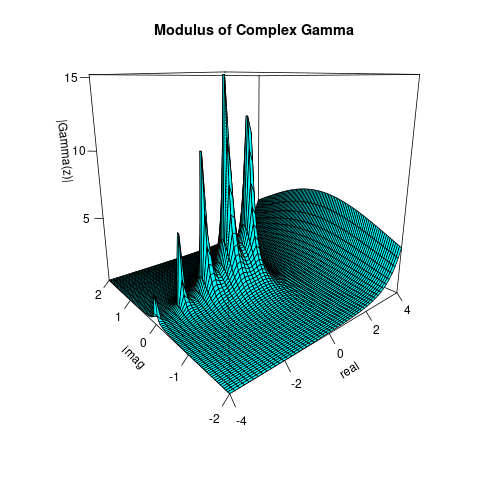

In [47]:
-- 3D plot of complex gamma function defined above
nreal = 50
nimag = 100
realRange = 8.0
imagRange = 4.0
dreal = realRange/fromIntegral (nreal-1) :: Double
dimag = imagRange/fromIntegral (nimag-1) :: Double
rvec = take nreal $ iterate (+ dreal) (-realRange/2.0)
ivec = take nimag $ iterate (+ dimag) (-imagRange/2.0)
magvec = [z | j <- [0..(nimag-1)], i <- [0..(nreal-1)], 
                let z = magnitude $ gamma $ rvec!!i :+ ivec!!j]
-- R stores 2d matrices by columns, so in m(i,j),  to
-- run through the rows of each column, we need a nested
-- loop where j is defined in the outer loop, and i is set
-- in the inner loop. This corresponds to the order of the
-- i and j assignments in the list comprehension.
[rgraph| magmatrix <- matrix(magvec_hs, 
                          nrow=length(rvec_hs), 
                          ncol=length(ivec_hs))
      persp(rvec_hs, ivec_hs, magmatrix,ticktype='detailed',theta=-40,
      main="Modulus of Complex Gamma",col='cyan',
      xlab='real',ylab='imag',zlab="|Gamma(z)|") |]

## Classical Daubechies (N=2) Wavelet

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAMAAABKCk6nAAADAFBMVEUAAAABAQECAgIDAwMEBAQFBQUGBgYHBwcICAgJCQkKCgoLCwsMDAwNDQ0ODg4PDw8QEBARERESEhITExMUFBQVFRUWFhYXFxcYGBgZGRkaGhobGxscHBwdHR0eHh4fHx8gICAhISEiIiIjIyMkJCQlJSUmJiYnJycoKCgpKSkqKiorKyssLCwtLS0uLi4vLy8wMDAxMTEyMjIzMzM0NDQ1NTU2NjY3Nzc4ODg5OTk6Ojo7Ozs8PDw9PT0+Pj4/Pz9AQEBBQUFCQkJDQ0NERERFRUVGRkZHR0dISEhJSUlKSkpLS0tMTExNTU1OTk5PT09QUFBRUVFSUlJTU1NUVFRVVVVWVlZXV1dYWFhZWVlaWlpbW1tcXFxdXV1eXl5fX19gYGBhYWFiYmJjY2NkZGRlZWVmZmZnZ2doaGhpaWlqampra2tsbGxtbW1ubm5vb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGSkpKTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tLS1tbW2tra3t7e4uLi5ubm6urq7u7u8vLy9vb2+vr6/v7/AwMDBwcHCwsLDw8PExMTFxcXGxsbHx8fIyMjJycnKysrLy8vMzMzNzc3Ozs7Pz8/Q0NDR0dHS0tLT09PU1NTV1dXW1tbX19fY2NjZ2dna2trb29vc3Nzd3d3e3t7f39/g4ODh4eHi4uLj4+Pk5OTl5eXm5ubn5+fo6Ojp6enq6urr6+vs7Ozt7e3u7u7v7+/w8PDx8fHy8vLz8/P09PT19fX29vb39/f4+Pj5+fn6+vr7+/v8/Pz9/f3+/v7////isF19AAAgAElEQVR4nO2deWDUxP7AB0QtWg6xIj4Beb4HqL+igMjVwlJLsS33ZSuKCJZDAQEBQW7kAUWQQ0QUyyEiAiKHnFpK0VKuB4IccjwQEBCQQrGU3u38ku1uu5vN7iaZSWYymc8f7TYz882XfthtMpkDQA7TANIJcPSFC2YcLphxuGDG4YIZhwtmHC6YcbhgxuGCGYcLZhwumHG4YMbhghmHC2YcLphxuGDG4YIZhwtmHC6YcbhgxuGCGYcLZhwumHHMIrgaACCwwZR8z5JT4N/yTTJBgOSFetyapqc5T7+03LkcAGYIr14D40rKT0c/9FiPS3BWhataT6cD5hH8r/o1AXjFs8S/4Kz6jbWe1k1wfXCw+MXfVXtCQXClG26Cs2qBxjVAcG7mwz21nk4HzCN4B4Tb7y3zq0eJf8EIyAv+EBwQBYNBboI3g+dhfg2QDEeW/R35xNgwlWDYDbwPf2xaoUrrw/A4eArC3aCpKHhmjVoTiyA83zGoaq/bwkdp3BOVWv8iytlWr0K3v4stOQtTW1Z4pMNxe8yGQszRoIMQ6nFn1FdBPITDwAhnddem9QWla+0Na9WFouBq5U67Cl4YOAbCWLAMHgWjiPyOZDGX4Jkg5kL5e1s3Bf90FVw2wFZBMJ9R7d7OoSCqsKgpeDa0TND1TFC2fDAAI+2WnIU3KpbtHAb+kS3GHA3+A18Ej8EloI8z6vegJYT1wAFnddem258AUy+J7U6Bt+yCvwCd3P4GCxQ+DXZDGNTA+F+QN8wleDFokRI7F966F6S7CBbeV3vAg3dng8EQNgebdoDaBbBHucWZAGyGX4AX7YKdhbvAv87DKQP+EGPuBG2LKlYFlweA1c6ouZXLpV8DtUqquzYt+YheBT6xC74QDXYJgrcDO52EksI4EC58a3lPEbnflARzCZ4FYuD+IS0qA5DmIri88H6sAQ6+UfyLjp8LetubZIL7imCKUEO05CzMegSAp4eetVfIffDhE2AcWN+wbJozKuwN1qwA75VUd21aIngBWF4s+MQ9jXqAcQcj7UyG8NZLIPSWUKEDuEXo1+SJuQTHgNE7ytaY/8vDouC6TsEBguBa4FAcGLhK4PAsMNzexP73c7dDsLMQ3vwsOgDcf8xeIxqMBRfvf7dcY+iMCn8Avd8QPDqruzV1Cl4GZhYLhgNAFZeP6N/rgjdyxBcRIMfgX493TCU46b4yR4aA8fCQ8F47C+7/G04t/ojeAA+CB+7OEd558PMRR7aC5/Lh64FfuQl2Fm4bvQ1mRoAF9qBzQVAt2DhIcOSMCvODqlX/Jyyp7tpUELzP3iwZ9HcIvl4BgHGH2tn5T24wGFqc7NPVSP2aPDGP4DqNnhTvg+eAilEPlAFX8h8BVesFFAt+oHUlQdLfj5R9tQP4V2ZhffBcqzKPpbkJdhZuBYGdu5e/t/gd/BsAsXAgACklUaHwpgSjYUl116awI4g+KjbLKR/mECz8Dyv9G7wOgGcbNWq0CaaXiSX6u3LDPIIBePC5yfkwu0eFp5c/B6bDpP8LtH1lF/z4gEdrTiyE8EzUQ4++Ljj66/XHK0WdcP+ILin8qlGlwMZbHFFrgLnwS1DBJSrcBcAhWFLdremu5wO32Zv1vPeGQ3BWjdKP6HHFopfBBOHijhrMIpgqDpeZ5au4ydP0XERzwZp48x8+rqJ2gu3GZeIXLlgLaQlXvBfuXm1cIv7hghmHC2YcLphxuGDG4YIZhwtmHC6YcbhgxuGCGYcLZhwumHG4YMbhghmHC2YcLphxuGDG4YIZhwtmHC6YcbhgxkEQfGMNhwLW5ukleHWPzznkCTmrm+AF2ttysPEmF8w2XDDjcMGMwwUzDhfMOFww43DBjMMFMw4XzDhcMONYTXBeIukMDMZqgpM7ks7AYLAIzpBbNoZOwe9Fk87AYJAFZ02tcz8oV3tyrrSATsFNXyKdgcEgC+7dafet/Ft7Yt6UFlAp+EK3cNIpGAyy4KAs+7eCmtICKgV/+mUr0ikYDLLgBuvt33Y2lBZQKbjjdS7YDf+C99WoFxMXW7/6IWkBjYKzW0Eu2A0FV9EFiQkzFiUVeBynUfAPE7lgdxi7Dx62lwt2hzHBoQVcsDv+BV855UBaQKHgcz0gF+yOf8HzAstVsyMtoFDwvK+5YAkKPqITgyUHMs7ZmeNzVWwiRN/kgiUoEJwv3Ypvez879dpoz0ofMsVeLC7YDYSLrKEx2tvqw8ZpkAuWoFhwusc69fQJjhM3ReGC3VAsONVjK0/qBBc1E79ywW6w9BG9d4j4lQt2A+GBP3WCR/wsfuWC3UB44E+d4OaF4lcu2A2EB/60Cf69eEO5VhTtSmUE+j3wp03wZ0vt31rnk03DaPR74E+b4K6X7d8iswnnYTD6PfCnTHBBSPH3dhlk8zAa/R74UyZ4n2Pz3i43yeZhNJa5D57o6GqLuUo2D6OxjOCw4otB2PMPsnkYjVUE32jneNHH9z+YOawi+Evn8IMBJ4nmYThWERx7wfFi8FGieRiORQQXhThfDT9IMg/jsYjgE3HOV6P3kszDeCwieN5K56vxP5PMw3gsIrjDdeerKTtI5mE81hCc37LkZfxWgnkQwBqCDwwteTl7I8E8CGANwbPWlbyc/y3BPAhgDcEdb5S8/Hylj3oMYg3BpX+C4ZIvyaVBAksIvhxb+nrFF+TyIIElBG+OL3299mNyeZDAEoIHu/RebZlBLg8SWEFwYVOXkZQ7J5FLhARWELxrpMsPe0cTy4MIVhA88IDLD0eGEMuDCBYQXOD6CQ1P9yOWCBEsIDjxfdef/pDOV2ccCwju7TaG40Y3UnmQgX3Bd1q6/ZjZllAehGBf8Mo5bj8WvEgoD0KwLzj2d/efbUSyIAbzgnNaSg5Y
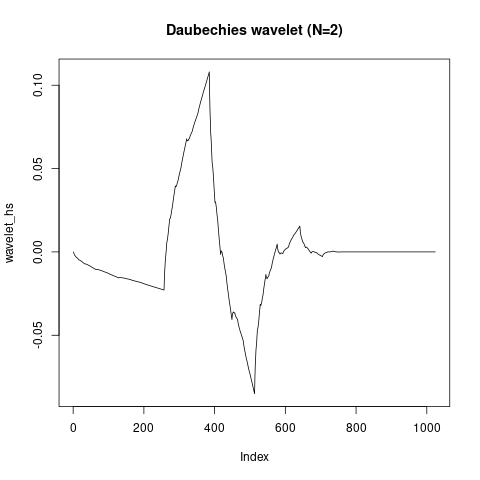

In [48]:
sig = deltaFunc 5 1024 -- unit mass at position 5
wavelet = iwt1d sig 2 0 10 -- inverse wavelet transform (N=2,1024=2^10)
[rgraph| plot(wavelet_hs,type='l',main="Daubechies wavelet (N=2)") |]

## FM radio spectrum analysis and demodulation

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAeAAAAHgCAIAAADytinCAAAgAElEQVR4nOydeVxU1fvHnxmGTRYZAREVFZVFcEMMVDTJVCo33EJb1K9GmSRl+M3U6ldafjPT1DLa3PekXMg9M8EFAcUVUVEWlVVGYNiHmfv74+TtMjMMs965d3jef/iae+fOOc+dkc+cec7nPEdAURQgCIIg3ENo7gAQBEEQ9aBAIwiCcBQUaARBEI6CAo0gCMJRUKARBEE4Cgo0giAIR0GBRhAE4Sgo0AiCIBwFBRpBEISjoEAjCIJwFBRoBEEQjoICjSAIwlFQoBEEQTgKCjSCIAhHQYFGEAThKCjQCIIgHAUFGkEQhKOgQCMIgnAUFGgEQRCOggKNIAjCUVCgEQRBOAoKNIIgCEdBgUYQBOEoKNC8x9PTU/AUJyenAQMGfP75542NjSyHcfPmTYFA0KtXL82XVVdXCwQCe3t7zZeVl5eXlZXpdBcaAhCLxQIV1q1bV1FRQR+eOHGCXHz16lX65M2bN5Wa8vHxYTYiFAq9vLzWrFmjX5xavhtKPH78+L333vP19bW3t+/SpcvEiRMvX75MntKvQW0wXcuIBkTmDgAxDj169HBycpJIJBkZGRkZGZmZmbt27TJ3UPrz3HPPXblyJT09PTg42Fht+vj4ODg40Ifu7u7MZ1NSUkaPHg0AaWlpLTbl7e3dtm1biqJKS0sfPnwYFxcXHBw8fPhwXUMSCoX9+/e3sbHR/iUymWzMmDGpqam2traBgYGZmZkHDhw4ceJEWlpaQECAHg0iXAZH0BbCjz/+mJGRkZeXd+zYMWtr6z179ly7ds3cQXGL7du3ZzB45ZVX6Kfs7OxSUlLI49TUVBsbG6FQ05/GN998k5GRceXKlQcPHvj7+wPAqVOn9AjJ3t4+IyPj4sWL2r/k8uXLqamprq6uRUVFly5devLkyciRI2tqan7++Wf9GkS4DAq0pRERETFhwgSKovbs2UPO5ObmRkZGuru7e3h4zJo1q6KiAgDu3bsnEAi8vb3fe+89FxeXbt26rV+//sKFC8HBwU5OTiNGjMjLyyMvr62t/eCDD/z8/JycnJ555hnmwFwikURFRbm6ugYFBV24cIE+r5RtOHfunEAgGDx4sGq0J0+eHDx4sLOzs6ur66hRo65cuQIAQUFB5MHAgQN/++235m5BQwC6EhwcTItaampqUFCQZoGmEQqFYWFhAEB++6u9HQ1xKuUNNLzVNEVFRQBga2tra2sLAHZ2dvHx8Vu2bBk3bpxqgzU1NTExMW5uboMHD/75558FAsHUqVMBoLi4WCAQuLu7HzhwoHfv3s7OzuPHjy8pKSGvau4uEDNAITynQ4cOAPDnn3/SZ1atWgUAUVFRFEVVVlZ26NDB2tp64sSJQ4cOBYAXX3xRLpdnZ2eT/wBt2rQJDAwkj21sbIg6AMDLL79MWnvhhRcAwMvLa8yYMW3atAGA+Ph4iqIUCsXAgQMBwNvbOzg4mCiav78/RVE3btygH1MUdfbsWQAYNGgQRVFVVVUAYGdnR1FUbm6uvb29tbX1yJEjBw0aRJqiKOrYsWNdu3YFgC+++OLBgwfN3YKGAJRwcXEhTw18yiuvvEJRVHl5ObnxuLg4ALhz5051dbWVldW7774rEokA4MaNG0pN9ezZEwAOHDhADouLi8kI+ty5c83djoY4me+GhreaSUFBgaOjIwC0b9/+1VdfXbt27YULF+RyOXlWqcHo6GgA6Ny5c1BQkLW1NQBMmTKFoiii8iKRyNbWtn///uRm33jjDQ0filLLCDugQPMeVYHeuHEjAAwbNoyiKDJ/NX/+fPLUkCFDACAxMZEItEAguH//PkVRRPhee+01iqJOnjxJK0hycjKRjIqKCoqiDh48CADu7u4URR0+fBgAunfvXltbS1HUjBkzdBXo5OTkadOmrV27lqIoiURCFOTJkycURfXv3x8A0tPTNdyChgCUIALNpH///hRDoPft2wcA27ZtI/e7e/duzQLNRCQSbdmyRcPtaIhT6d1o7q1W4sKFC+Hh4SRCgpeXV1JSklKD5EdSmzZtJBIJRVFjx45VEmjyvUJR1Pbt2wGgb9++Gu4CBdosYIrDAnny5AkAdOzYEQBIJvrbb78lroPz588DAG1O8PLy8vb2BoDOnTsDwHPPPUdOAgBxUFy9ehUAxo0b5+zsDAAvvPCCg4NDaWlpYWFheno6ecrOzg4AZs6cqWucQ4cOXbBgQU5OzrPPPtu9e3eZTAYAcrlc6bLmbkHXAFJSUuj/9xkZGcyngoKCbGxsUlJSUlNTASA0NFRzU97e3v379+/bt6+NjU1jYyMZUDd3O1rGqeGtVrpy0KBBp0+ffvLkSXJy8ldffeXr6/vgwYNXX31V6bIrV65QFBUWFiYWiwFg8uTJSheIxWLybUcG+DU1NaD1h4KwA7o4LBDiQyDKS8ZZMTExw4YNoy/w8/MjD5QyrVZWVkpNURQFAAKBgBza2Ni0bdu2urq6sbFRKpUyW1C1xJHXauDUqVOjR4/u1KnTBx98sG7dulGjRpWVlale1twt7Ny5U3MA2mNnZxcUFHTx4kWJRNK+fXvy1mngm2++mTBhAgAUFhZ26dLlwIED9+7dy8vLU3s7Lb5RBA1vNfOyc+fOnT17tk+fPi+99NLQoUOHDh06YcIEPz+/Bw8elJeXkwEvgQgu7eggXw9M6I+b7hS0/lAQdsARtKXx119/7d+/XyAQTJs2DQBIftnBwSEqKioqKqqioiI9PZ35B6mZfv36AUBiYiL5hfv3338XFBS4urp6eXkRlU9MTKyvrweAvXv30q8iWpCbm1tZWQkAZ86cUdt4YmKiQqGYNWvWO++8Q1GUqhAQbWruFjQEoAeDBg26evVqcnJyi8NnJp6enp06dQKAwsLC5m5Hyzg1vNXMy0pKSj788MO3336bTlMUFxcDgKurq1ImJyAgAACSkpLIN8Tvv/+uzR21+KEgrGKGtApiVEgO2tfXd+DAgd27dycf6/Tp08mzFRUV7u7uQqHw1VdfHT9+PAD06NGjqqqK5KC7detGLiNqTnKpWVlZANCzZ0/y1KhRowDA29s7MjKS+Ig3bNhAUZREIiGHPj4+gwcPJqJPUqsymYy4jNu3b9+nTx+i16o56G+++QYAnJ2dX3zxxTZt2pAWHj16RFEUGZ++9NJL165da+4WNASgBFEuZoqDQOegHz58uHv3bvL4iy++oChKy0lCiqK6desGAMeOHWvudjTEqZTYbe6tZlJXVxcSEgIAbdq0CQsL8/HxIWGvWrVKtUHym6N79+6hoaGkX2YO2s3NjVzG/MSbuwvMQZsFHEFbCHfu3ElPTy8uLu7Xr99nn322bds2ct7Z2fncuXMRERFHjhy5ePHijBkzkpKSmOs1WuTAgQPvv/++SCT6888//f39t2/fPm/ePAAQi8XHjh17/vnnS0pKpFLphg0b6JeIRKI9e/YEBgbW1NS0a9eOWHRVmTt3LnFT5Obm/vDDD3379gUAEvmCBQuCg4OTkpIePXrU3C1oCEAPiGMBtEhAK0G+FP/444/mbkf7OJt7q5nY2toeO3Zs8eLFXbt2zcjIqKioGDZs2J49exYuXKja4O+//z558mSJRNLQ0LBu3TptbkfDh4Kwj4BqKVGIIAgfkUgkycnJtra2xL23Zs2auLi49957j4yREV6Ak4QIYpnI5fJXX321urp6yZIlbm5uq1atEgqFU6ZMMXdciA7gCBpBLJYLFy589NFHGRkZcrk8MDBwyZIlxA2N8AUUaARBEI6Ck4QIgiAcBQUaQRCEo6BAIwiCcBQUaARBEI6CAo0gCMJRUKARBEE4Cgo0giAIR0GBRhAE4Sgo0AiCIBwFBRpBEISjoEAjCIJwFBRoBEEQjoICjSAIwlFQoBEEQTgKCjSCIAhHQYFGEAThKCjQCIIgHAUFGkEQhKOgQCMIgnAUnu3q
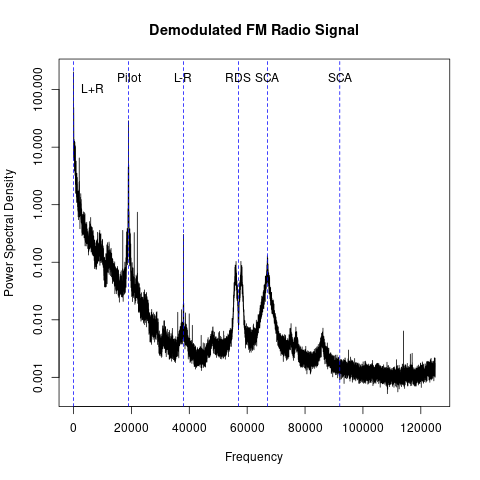

In [49]:
-- Change path in readBin command for your system if needed.
[rgraph| library(signal) ## for unwrap() and decimate()
      library(tuneR)  ## to save .wav file
      
      ## Read FM radio IQ data from pySDR online book.
      ## The station frequency is not really needed because it has                         
      ## already been down-converted to 0 Hz.
      freq <- 99.5*1e6 ## 99.5 MHz down-converted to 0 Hz.
      fs <- 250000 ## sample rate 250k
      samples <- 1000000 ## 1M IQ samples

      ## download.file() does not work in a quasiquote (SSL connect error).
      ## Use a browser to download.
      ##url <- "https://github.com/777arc/498x/blob/master/fm_rds_250k_1Msamples.iq?raw=true"
      ##download.file(url,"examples/tutorial/fm2_rds_250k_1Msamples.iq")
           
      ## Read 2M doubles (1M complex numbers) saved using Python.
      ## Assumes current working directory is HaskellR/IHaskell/examples.
      ## Adjust path if needed.
      fmiqraw <- readBin("../../examples/tutorial/fm_rds_250k_1Msamples.iq",
                         "numeric", size=4, n=2000000, endian = "little")
      realPart <- fmiqraw[seq(1,length(fmiqraw),2)]           
      imagPart <- fmiqraw[seq(2,length(fmiqraw),2)]
      fmiq <- complex(real=realPart,imaginary=imagPart)

      ## Simple demodulation (no deemphasis or stereo decoding)
      ## This approximates the derivative of the phase (FM).
      arg <- Arg(fmiq)
      un <- unwrap(arg)
      demod <- diff(un)

      ## Spectral analysis of demodulated signal
      ser <- ts(abs(demod), fs)
      sp <- spectrum(ser, kernel=kernel("daniell", 28), plot=FALSE)
      options(scipen=5) ## No scientific notation on axes
      plot(sp$freq*fs, sp$spec, type='l', log='y',
           xlab='Frequency', ylab='Power Spectral Density',
           main='Demodulated FM Radio Signal')
      color <- 'blue'
      voffset <- 100.0
      abline(v=0,lty=2,col=color); text(0, voffset, pos=4, 'L+R')
      abline(v=19000,lty=2,col=color); text(19000, voffset, pos=3, 'Pilot')
      abline(v=38000,lty=2,col=color); text(38000, voffset, pos=3, 'L-R')
      abline(v=57000,lty=2,col=color); text(57000, voffset, pos=3, 'RDS')
      abline(v=67000,lty=2,col=color); text(67000, voffset, pos=3, 'SCA')
      abline(v=92000,lty=2,col=color); text(92000, voffset, pos=3, 'SCA')

      ## Decimate since we don't care about anything above audio frequencies,
      ## and we don't want to create a huge .wav file. Note that Ubuntu
      ## Desktop may have a problem playing wav files (use play cmd or browser).
      decimateFactor=20 ## about 100/20 or 5 kHz is sufficient for mono audio.
      demod <- decimate(demod, decimateFactor, ftype='fir')
      fs <- fs/decimateFactor

      ## Normalize the result and save to audio file (saved to examples directory)
      maxdemod <- max(demod)
      mindemod <- min(demod)
      demod <- demod/max(maxdemod,-mindemod) ## normalize
      w <- Wave(demod, samp.rate=fs, bit=32, pcm=FALSE)
      writeWave(w,'tutorial.wav') |]

## Use Rcpp to compile and use C++ code in R on the fly

In [50]:
-- Here a C++ function named cpptest is compiled and bound dynamically
-- with the embedded R instance, then called at the end of the quasiquote.
[rprint| library(Rcpp)
  Rcpp::sourceCpp(code='
  #include <Rcpp.h>
  // [[Rcpp::export()]]
  SEXP cpptest(Rcpp::NumericVector v, Rcpp::NumericVector w) {
    Rcpp::NumericVector wcopy = Rcpp::clone(w);
    for(int i = 0; i < v.size(); ++i) {
      v(i) = 100.0 + i; // update in place by default
      wcopy(i) = 200.0 + i;
    }  
    return wcopy;
  }')
  ## R code that uses C++ function compiled above
  v <- as.double(1:5)
  w <- as.double(1:5)
  list(returnvalue=cpptest(v,w),
  v=v, w=w) |]

$returnvalue
[1] 200 201 202 203 204

$v
[1] 100 101 102 103 104

$w
[1] 1 2 3 4 5

## Using R's parser

In [51]:
x <- [r| parse(text="sqrt(2*log(7))") |] -- build parse tree
y = H.cast R.SExpr x -- cast to SExpr
H.eval y >>= I.printR -- eval and print

[1] 1.97277

## Inspecting the underlying SEXP

In [ ]:
-- To view details about the underlying SEXP we can use the debugging function D.inspect.
-- The result is in JSON format and can be navigated using a JSON viewer.
-- HaskellR works primarily with the "head" of the structure for efficiency.
sxp <- [r| sqrt(1:5) |]
R.unSomeSEXP sxp (putStrLn . D.inspect)

{"Real":[1,1.4142135623730951,1.7320508075688772,2,2.23606797749979],"attributes":{"Nil":"NilValue","attributes":"loop","header":{"debug":false,"gp":0,"mark":true,"named":65535,"obj":false,"spare":false,"trace":false,"type":"Nil"}},"header":{"debug":false,"gp":0,"mark":false,"named":1,"obj":false,"spare":false,"trace":false,"type":"Real"}}